In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from inspect import isfunction
import inspect
import math
import numpy as np
import pandas as pd
import itertools
import heapq
import logging
import gc

#### Logging setup

In [29]:
# Configure the logger
logger = logging.getLogger('loggy')

if not logger.handlers:
    # Execute this only once to avoid adding multiple handlers
    logger.setLevel(logging.WARNING)  # Default level
    handler = logging.StreamHandler()
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S')
    handler.setFormatter(formatter)
    logger.addHandler(handler)

# debug -> info -> warning -> error -> critical
def update_logger_level(new_level):
    """Updates the logger's level."""
    level = getattr(logging, new_level.upper(), None)
    if level is not None:
        logger.setLevel(level)
    else:
        logger.warning("Invalid logging level:", new_level)

#### Loading the data

In [30]:
features = np.genfromtxt("./data/features.txt", delimiter=",")
targets = np.genfromtxt("./data/targets.txt", delimiter=",")
unknown = np.genfromtxt("./data/unknown.txt", delimiter=",")

In [31]:
def custom_split(features, targets, test_size=0.1, validation_size=0.1, random_state=None):
    # Set random seed for reproducibility
    np.random.seed(random_state)

    # Shuffle indices
    indices = np.arange(len(features))
    np.random.shuffle(indices)

    # Determine sizes of train, validation, and test sets
    num_samples = len(features)
    num_validation = int(num_samples * validation_size)
    num_test = int(num_samples * test_size)
    num_train = num_samples - num_validation - num_test

    # Split indices
    train_indices = indices[:num_train]
    val_indices = indices[num_train:num_train + num_validation]
    test_indices = indices[num_train + num_validation:]

    # Split data based on indices
    features_train = features[train_indices]
    features_val = features[val_indices]
    features_test = features[test_indices]
    targets_train = targets[train_indices]
    targets_val = targets[val_indices]
    targets_test = targets[test_indices]

    return features_train, features_val, features_test, targets_train, targets_val, targets_test

In [32]:
features_train, features_val, features_test, targets_train, targets_val, targets_test = custom_split(features, targets, test_size=0.1, validation_size=0.1, random_state=42)

In [33]:
print(targets_train.shape)

(6284,)


# Custom MLP implementation

### Helpers

##### mlp functions

In [41]:
class mlp_func:
    """
    This class stores functions for activation functions, loss functions, and their derivatives.

    Also includes some shared functionality.

    The class is accessed:
        func.SIGMOID (func.FUNCTION_NAME)
    """

    ## ACTIVATIONS
    SIGMOID = staticmethod(lambda x: 1 / (1 + np.exp(-x)))
    DSIGMOID = staticmethod(lambda x: (1 / (1 + np.exp(-x))) * (1 - (1 / (1 + np.exp(-x)))))

    TANH = staticmethod(lambda x: np.tanh(x))
    DTANH = staticmethod(lambda x: 1 - np.power(np.tanh(x), 2))

    ReLU = staticmethod(lambda x: np.where(x > 0, x, 0))
    DReLU = staticmethod(lambda x: np.where(x > 0, 1, 0))

    LReLU = staticmethod(lambda x, eps=1e-5: np.where(x > 0, x, x*eps))
    DLReLU = staticmethod(lambda x, eps=1e-5: np.where(x > 0, 1, eps))

    SOFTMAX = staticmethod(lambda x: np.exp(x - np.max(x, axis=1, keepdims=True)) / np.sum(np.exp(x - np.max(x, axis=1, keepdims=True)), axis=1, keepdims=True))
    # No softmax derivitive implementation, only the "cheat" one with cross entropy

    REGRESSION = staticmethod(lambda x: x)
    DREGRESSION = staticmethod(lambda x: 1)


    ## LOSS FUNCTIONS
    MSE = staticmethod(lambda y_true, y_pred: np.mean(np.power((y_true - y_pred), 2)))
    DMSE = staticmethod(lambda y_true, y_pred: (y_pred - y_true) / y_true.shape[0])

    CROSS_ENTROPY = staticmethod(lambda y_true, y_pred, eps=1e-15: -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1)))
    DCROSS_ENTROPY = staticmethod(lambda y_true, y_pred: y_pred - y_true)


    ## REGULARIZATION
    L2REG = staticmethod(lambda weights, lambda_reg: 2 * lambda_reg * weights)
    L1REG = staticmethod(lambda weights, lambda_reg: np.sign(weights) * lambda_reg)
    NONE = staticmethod(lambda weights, lambda_reg: np.zeros_like(weights))


    @classmethod
    def validHiddenActivation(cls, function) -> bool:
        """Checks if function is a valid, predefined, hidden activation"""
        return function in [cls.SIGMOID, cls.TANH, cls.ReLU, cls.LReLU]
    
    @classmethod
    def validOutputActivation(cls, function) -> bool:
        """Checks if function is a valid, predefined, output activation"""
        return function in [cls.SIGMOID, cls.SOFTMAX, cls.REGRESSION]
    
    @classmethod
    def validLossFunction(cls, function) -> bool:
        """Checks if function is a valid, predefined, loss function"""
        return function in [cls.MSE, cls.CROSS_ENTROPY]
    
    @classmethod
    def validRegFunction(cls, function) -> bool:
        """Checks if function is a valid, predefined, regularization function"""
        return function in [cls.NONE, cls.L1REG, cls.L2REG]
    
    @classmethod
    def validate_custom(cls, function, role):
        """
        Validates custom function
        Checks args and output shape

            NOTE : No implementation for custom dervitives, so custom functions dont work!

            Args: 
                function: function to check
                role: role the function will fufill 
        """
        if not isfunction(function):
            raise ValueError(f"Custom {role} function must be callable, was {function.type()}")
        
        arg_spec = inspect.getfullargspec(function)
        args = arg_spec.args
        defaults = arg_spec.defaults if arg_spec.defaults is not None else []
        
        # Expected arguments
        expected_args = {
            "loss": ["y_true", "y_pred", "eps"],
            "output": ["x", "eps"],
            "hidden": ["x", "eps"],
            "regularization": ["weights", "lambda_reg", "eps"]
        }
        
        # Validate args
        if role not in expected_args:
            raise ValueError(f"Invalid function type: {role}. Must be one of {list(expected_args.keys())}")
        
        missing_args = [arg for arg in expected_args[role] if arg != 'eps' and arg not in args]
        if missing_args:
            raise ValueError(f"Missing required arguments for {role} function: {missing_args}")
        
        unexpected_args = [arg for arg in args if arg not in expected_args[role]]
        if unexpected_args:
            raise ValueError(f"Unexpected arguments for {role} function: {unexpected_args}")
        

        # Check for epsilon default value if eps is expected, must have a default value
        if 'eps' in expected_args[role] and 'eps' in args:
            eps_index = args.index('eps') - (len(args) - len(defaults)) 
            if eps_index >= 0:
                eps_default = defaults[eps_index]
                if eps_default is None:
                    raise ValueError("Epsilon parameter must have a default value")
            else:
                # Epsilon is expected but no default value is provided
                raise ValueError("Epsilon parameter is expected to have a default value but none was provided")


        # validate shape (can be changed later)
        dummy_input_shapes = {
            "loss": {"shapes": [(10, 1), (10, 1)], "validation":cls._validate_shape_loss},
            "output": {"shapes": (25, 50), "validation":cls._validate_shape_actiavation}, 
            "input": {"shapes": (25, 50), "validation":cls._validate_shape_actiavation}, 
            "regularization": {"shapes": (100, 125), "validation":cls._validate_shape_regularization}
        }

        dummy_input_shapes[role]["validation"](function, dummy_input_shapes[role]["shapes"])

    
    @classmethod
    def _validate_shape_loss(cls, function, shapes):
        """Validates shape for loss function"""
        dummy_y_true = np.random.rand(*shapes[0])
        dummy_y_pred = np.random.rand(*shapes[1])
        output = function(dummy_y_true, dummy_y_pred)

        if not np.isscalar(output) and output.shape != (shapes[0][0], 1):
            raise ValueError(f"loss function shape was unexpected, should be scalar or {(shapes[0][0], 1)}, was {output.shape}")
        
    @classmethod
    def _validate_shape_actiavation(cls, function, input_shape):
        """Validates shape for activation function"""
        dummy_input = np.random.rand(*input_shape)
        output = function(dummy_input)

        if not output.shape == input_shape:
            raise ValueError(f"activation function shape was unexpected. Should be {input_shape}, was {output.shape}")
        
    @classmethod
    def _validate_shape_regularization(cls, function, weights_shape):
        """Validates shape for regularization function"""
        dummy_weights = np.random.rand(*weights_shape)
        dummy_lambda = 0.001
        output = function(dummy_weights, dummy_lambda)

        if not output.shape == weights_shape:
            raise ValueError(f"regularization function shape was unexpected. Should be {weights_shape}, was {output.shape}")
        
    
    @classmethod
    def derv(cls, function):
        """
        Retrieves the derivative function of a given function.

        Args:
            function: The function to derivate

        Returns:
            The derivative function if it exists, otherwise raises a ValueError.

        """
        FUNC_TO_DERV = {cls.SIGMOID:cls.DSIGMOID, cls.TANH:cls.DTANH, cls.ReLU:cls.DReLU, cls.LReLU:cls.DReLU,
                        cls.REGRESSION:cls.DREGRESSION, cls.MSE:cls.DMSE, cls.CROSS_ENTROPY:cls.DCROSS_ENTROPY}

        if function == cls.SOFTMAX:
            raise ValueError("Softmax derivitive not implemented")
            
        if (not function in FUNC_TO_DERV):
            raise ValueError(f"Derivative not found for function : {func_parser.convert_func(function)}")
        
        return FUNC_TO_DERV[function]

##### init functions

In [42]:
class init_func:
    """
    Class for initializing weights for a layer
    """

    ## Initialization strategies
    RANDOM = staticmethod(lambda input_size, layer_size: np.random.rand(input_size, layer_size))
    GUASSIAN = staticmethod(lambda input_size, layer_size: np.random.normal(0, 1, (input_size, layer_size)))
    XAVIER = staticmethod(lambda input_size, layer_size: np.random.normal(0, np.sqrt(1 / input_size), (input_size, layer_size)))
    HE = staticmethod(lambda input_size, layer_size: np.random.normal(0, np.sqrt(2. / input_size), (input_size, layer_size)))
    
    CONST_BIAS = staticmethod(lambda layer_size, const=0: np.ones(layer_size) * const)
    XAVIER_BIAS = staticmethod(lambda layer_size, const=1: const * np.random.uniform(-np.sqrt(1. / layer_size), np.sqrt(1. / layer_size), (layer_size)))
    ZERO_BIAS = staticmethod(lambda layer_size, const=None: np.zeros(layer_size))
        
    @classmethod
    def validate_custom_init(cls, init_method, input_size, layer_size):
        """
        validates custom initialization function
        - is function
        - takes 2 arguments
        - return ndarray with shape (layer_size, input_size)

        Args:
            init_method: custom init function to use
            input_size: size of the input (layer before)
            layer_size: size of the current layer

        Returns:
            initialized ndarray (layer_size, input_size)

        Raises:
            ValueError: if not a valid initialization function
        """
        if not isfunction(init_method):
            raise ValueError(f"custom initialization requires passing a custom function to init_method, was : {init_method.type()}")
        if init_method.__code__.co_argcount != 2: 
            raise ValueError(f"custom initialization function must take 2 paramaters, has {init_method.__code__.co_argcount}")
        
        w_test = init_method(input_size, layer_size)

        if not isinstance(w_test, np.ndarray):
            raise ValueError(f"custom initialization function must return ndarray, was {w_test.type()}")
        if w_test.shape != (input_size, layer_size):
            raise ValueError(f"Custome initialize function must return ndarray with shape {(layer_size, input_size)}, was {w_test.shape()}")
        return True

    @classmethod
    def validInitFunc(cls, init_method):
        """
        Validates initialization function

        Args:
            init_method: init function to validate

        Raises:
            ValueError: init_method is not a function or not in the list of valid functions
        """ 
        VALID_INIT_FUNCS = [cls.RANDOM, cls.GUASSIAN, cls.XAVIER, cls.HE]

        if not isfunction(init_method): 
            raise ValueError(f"Init method did not evaluate to function, was {init_method.type()}")
        
        if init_method in VALID_INIT_FUNCS: 
            return True
        
        if init_method not in VALID_INIT_FUNCS and cls.validate_custom_init(init_method):
            return True
        
        raise ValueError("Invalid custom init passed, this message show never be shown")
        
    @classmethod
    def validBiasFunc(cls, init_bias):
        VALID_BIAS = [cls.CONST_BIAS, cls.XAVIER_BIAS,init_func.ZERO_BIAS]
        return init_bias in VALID_BIAS 

##### function parser

In [43]:
class func_parser:
    """
    Parses and validates functions for the mlp. Also handles custom function validation

    Uses mlp_func and init_func
    """


    ## Conversion dicts
    STR_TO_FUNC = {
        "sigmoid":mlp_func.SIGMOID, "tanh":mlp_func.TANH, "relu":mlp_func.ReLU, 
        "lrelu":mlp_func.LReLU, "softmax":mlp_func.SOFTMAX, 'regression':mlp_func.REGRESSION,
        'mse':mlp_func.MSE, 'cross_entropy':mlp_func.CROSS_ENTROPY, 
        "l2":mlp_func.L2REG, 'l1': mlp_func.L1REG, 'none':mlp_func.NONE,
        "random":init_func.RANDOM, "guassian":init_func.GUASSIAN, 
        "xavier":init_func.XAVIER, "he":init_func.HE, "xavier_bias":init_func.XAVIER_BIAS, 
        "const_bias":init_func.CONST_BIAS, "zero_bias":init_func.ZERO_BIAS
    }
    ROLE_TO_VALIDATION = {
        "hidden":mlp_func.validHiddenActivation, "output":mlp_func.validOutputActivation, 
        "loss":mlp_func.validLossFunction, "regularization":mlp_func.validRegFunction,
        "init":init_func.validInitFunc, "bias":init_func.validBiasFunc
    }
    ROLE_TO_FUNC = {
        "hidden": [mlp_func.SIGMOID, mlp_func.TANH, mlp_func.ReLU, mlp_func.LReLU],
        "output": [mlp_func.SIGMOID, mlp_func.SOFTMAX, mlp_func.REGRESSION],
        "loss": [mlp_func.MSE, mlp_func.CROSS_ENTROPY],
        "regularization": [mlp_func.NONE, mlp_func.L1REG, mlp_func.L2REG],
        "init": [init_func.RANDOM, init_func.GUASSIAN, 
                 init_func.XAVIER, init_func.HE],
        "bias": [init_func.XAVIER_BIAS, init_func.CONST_BIAS, init_func.ZERO_BIAS]
    }


    @classmethod
    def convert_and_validate(cls, function, role=None):
        """
        Converts and validates input function

        Args:
            function: Input function. Can be valid function string, predefined function, or custom function
            role: What role? ["hidden", "output", "loss", "regularization", "init"] default None and 
                auto inferrence, must pass explicit role if using a custom function.

        Returns:
            converted and validated function

        Raises:
            ValueError if function cannot be converted or if function or role invalid
        """
        function = cls.convert(function)

        if role == None:
            role = cls._role_from_function(function)

        valid = cls.validate(function, role)
        if not valid:
            raise ValueError("Invalid function! [This error should not be raised]")
        
        return function

    @classmethod
    def convert(cls, function):
        """
        Converts string to function if needed.

        Args:
            function: Function to be converted. String or callable (goes straight through)
        
        Returns:
            valid function

        Raises:
            ValueError if function is not string or callable, or invalid function string.
        """
        if isfunction(function):
            return function
        
        elif isinstance(function, str):
            function = function.lower()
            if cls._valid_str_for_conversion(function):
                return cls.STR_TO_FUNC[function]
            raise ValueError(f"Invalid function string: {function}")
        
        raise ValueError(f"function must be of type function or string, was {function.type()}")

    @classmethod
    def validate(cls, function, role):
        """
        Validates function for role
        Checks if it is predefined or custom. Different validation

        Args:
            function: callable function
            role: What role? ["hidden", "output", "loss", "regularization", "init"]

        Returns:
            Boolean indicating wether the function was valid, invalid functions should raise errors

        Raises:
            ValueError if function is not callable, invalid for the role, or fails custom checks.
        """
        if not isfunction(function):
            raise ValueError(f"Function was not converted before validation!") 
        
        if cls._is_predifined_func(function) and not cls.ROLE_TO_VALIDATION[role](function):
            raise ValueError(f"Function {function} not valid for {role}")
        elif cls._is_predifined_func(function):
            return cls.ROLE_TO_VALIDATION[role](function)
        
        if role == "init": 
            return init_func.validate_custom_init(function, 10, 20)
        else: 
            return mlp_func.validate_custom(function, role)
                

    @classmethod
    def _valid_str_for_conversion(cls, function: str):
        """
        Checks wether a string is valid for conversion

        Args:
            function: function string

        Returns:
            Boolean indicating wether function string can be converted..
        """
        if function in cls.STR_TO_FUNC.keys():
            return True
        return False
    
    @classmethod
    def _is_predifined_func(cls, function):
        """
        Checks wether a function is a predefined one.

        Args:
            function: callable function to check

        Returns:
            boolean indicating wether function is predefined

        Raises:
            ValueError if function is not callable.
        """
        if not isfunction(function):
            raise ValueError(f"_is_predifined_func only accepts functions, was {function.type()}")
        return function in cls.STR_TO_FUNC.values()
    
    @classmethod
    def _find_key(cls, dict, val):
        """
        Finds key in dictionary based on presense of value

        Args:
            dict: dict to check, has to have collection of values
            val: val to look for

        Returns:
            first key that contains val in its values, None if none match
        """
        for key, values in dict:
            if val in values:
                return key
        return None

    @classmethod
    def _role_from_function(cls, function):
        """
        Infers role from function, only works for predefined ones.

        Args:
            function: callable function

        Returns:
            role inferred from function

        Raises:
            ValueError if role could not be inferred or if function passed is not predefined.
        """
        role = cls._find_key(cls.ROLE_TO_FUNC, function)
        if role == None and cls._is_predifined_func(function):
            raise ValueError("Role was not able to be inffered from function")
        elif role == None:
            raise ValueError("Role can only be inffered from predefined functions, not custom ones")
        
        return role
    
    @classmethod
    def convert_func(cls, function):
        """Converts function to its string representation"""
        if not isfunction(function):
            raise ValueError(f"convert_func must be called with function, was {function.type}")

        if function in cls.STR_TO_FUNC.values():
            for key, value in cls.STR_TO_FUNC.items():
                if value == function:
                    return key
                
        return None

##### MLP helper functions

In [44]:
class MLP_helper:

    logger = logging.getLogger("loggy")

    @classmethod
    def convert_and_validate_functions(cls, activation_hidden, activation_output, loss_function, regularization, init_method, init_bias):
        hidden = func_parser.convert_and_validate(activation_hidden, "hidden")
        output = func_parser.convert_and_validate(activation_output, "output")
        loss = func_parser.convert_and_validate(loss_function, "loss")
        reg = func_parser.convert_and_validate(regularization, "regularization")
        init = func_parser.convert_and_validate(init_method, "init")
        bias = func_parser.convert_and_validate(init_bias, 'bias')

        return hidden, output, loss, reg, init, bias
    
    @classmethod
    def create_layers(cls, sizes, act_hidden, act_output, init, init_bias, bias_const, reg, reg_lambda):
        layers = []
        for i in range(0, len(sizes) - 2):
            l = Layer(input_size=sizes[i], layer_size=sizes[i + 1], activation_func=act_hidden,
                      init_method=init, init_bias=init_bias, bias_const=bias_const, regularization=reg, reg_lambda=reg_lambda)
            layers.append(l)

        output = Layer(input_size=sizes[-2], layer_size=sizes[-1], activation_func=act_output,
                       init_method=init, init_bias=init_bias, bias_const=bias_const, regularization=reg, reg_lambda=reg_lambda)
        
        return layers + [output]
    
    @classmethod
    def get_subset(cls, input_data, target_data, subset_ratio = 0.2):
        total_samples = input_data.shape[0]
        subset_size = int(total_samples * subset_ratio)

        # Generate random indices
        indices = np.random.choice(total_samples, subset_size, replace=False)

        subset_input_data = input_data[indices]
        subset_target_data = target_data[indices]

        return (subset_input_data, subset_target_data)
    
    @classmethod
    def k_fold_split(cls, input_data, target_data, k_folds=5):
        # Handle case where k < 2
        if k_folds < 2:
            logger.warning(f"Attempted to split data into {k_folds}, returned NONE")
            return None
            
        # Shuffle indices
        indices = np.arange(input_data.shape[0])
        np.random.shuffle(indices)
        
        # Create folds
        fold_sizes = input_data.shape[0] // k_folds
        folds = []
        for i in range(k_folds):
            start = i * fold_sizes
            end = (i + 1) * fold_sizes if i != k_folds-1 else input_data.shape[0]
            test_indices = indices[start:end]
            train_indices = np.concatenate([indices[:start], indices[end:]])
            folds.append((input_data[train_indices], target_data[train_indices], input_data[test_indices], target_data[test_indices]))
        return folds

#### Normalization

In [45]:
class Normalization:
    @staticmethod
    def min_max_scale(data):
        df = data.copy()
        mins = np.min(df, axis=0)  
        maxs = np.max(df, axis=0)  
        denom = maxs - mins  
        denom[denom == 0] = 1  # Handle cases where max == min (set to 1 to avoid NaN)
        return (df - mins) / denom
    
    @staticmethod
    def z_score(data):
        df = data.copy()
        eps = 1e-8  
        means = np.mean(df, axis=0)
        stds = np.std(df, axis=0)
        stds[stds == 0] = eps  # Handle cases where standard deviation is 0
        return (df - means) / stds
    
    @staticmethod
    def mean_shift(data):
        df = data.copy()
        scaled_df = df - df.mean()
        return scaled_df

### Model implementation

##### Layer class

In [46]:
class Layer:
    """
    Represents a single layer in an artificial neural network (ANN). This class can be extended to create different types of layers.
    Each layer has an input size, layer size, activation function, and optional initialization method and regularization.
    """
    def __init__(self, input_size, layer_size, activation_func, init_method = None, init_bias='const_bias', bias_const=0, regularization = None, reg_lambda = 0.01) -> None:
        """
        Initializes the layer with the specified parameters.

        Args:
            input_size (int): The size of the input vector.
            layer_size (int): The number of neurons in the layer.
            activation_func (callable): The activation function to use for neurons in the layer.
            init_method (callable, optional): The method used to initialize the weights. Defaults to None.
            regularization (callable, optional): The regularization function to apply to the weights. Defaults to None.
            reg_lambda (float, optional): The regularization lambda parameter. Defaults to 0.01.
        """
        self.input_size = input_size
        self.layer_size = layer_size
        self.activation_func = activation_func
        self.init_method = init_method

        self.freeze = False
        self.weights = None
        self.bias = None
        self.x_values = []
        self.logger = logging.getLogger('loggy')

        self._init_regularization(regularization, reg_lambda)
        
        ## Initialize weights if init method available
        if init_method: self.initialize_weights(init_method, init_bias, bias_const)

    def _init_regularization(self, regularization, reg_lambda):
        """
        Initializes the regularization method and lambda for the layer.

        Args:
            regularization (callable): The regularization function to apply to the weights.
            reg_lambda (float): The regularization lambda parameter.
        """
        if regularization == None: regularization = mlp_func.NONE
            
        self.regularization = regularization
        self.reg_lambda = reg_lambda   

    def _apply_regularization(self):
        """
        Applies regularization to the layer's weights based on the defined regularization method and lambda.

        Returns:
            The regularization penalty to be applied to the weights.
        """
        return self.regularization(self.weights, self.reg_lambda)  
        
    def initialize_weights(self, init_method, init_bias, bias_const):
        """
        Initializes the layer's weights and biases using the specified initialization method.

        Args:
            init_method (callable): The method used to initialize the weights.
        """
        self.weights = init_method(self.input_size, self.layer_size)
        self.bias = init_bias(self.layer_size, bias_const)
        self.logger.debug(f"initial bias : {self.bias}")
        self.init_bias = init_bias
        self.bias_const = bias_const
        self.init_method = init_method

        self.initial_weights = self.weights.copy()
        self.initial_bias = self.bias.copy()


    def forward(self, input_batch):
        """
        Performs the forward pass of the layer using the given input batch.
        Called from MLP when preforming forward pass

        Args:
            input_batch (np.ndarray): The input data batch to process.

        Returns:
            np.ndarray: The output of the layer after applying the weights, biases, and activation function.

        Raises:
            ValueError: If the input batch size does not match the expected input size of the layer.
        """
        if self.weights is None or not self.init_method:
            raise ValueError("Layer weights have not been initialized!")
        
        if input_batch.shape[1] != self.input_size:
            raise ValueError(f"Actual input size does not match defined, was {input_batch.shape[1]}, should be {self.input_size}")

        z = np.dot(input_batch, self.weights) + self.bias
        x = self.activation_func(z)
        
        self.last_input = input_batch
        self.x_values.append(x)

        return x
    
    def calculate_gradient(self, output_error_batch):
        """
        Calculates the gradients for the layer's weights and biases based on the output error.

        Args:
            output_error_batch (np.ndarray): The error between the predicted and actual outputs.

        Returns:
            tuple: A tuple containing the gradients for the weights, biases, and the error to propagate to the previous layer.
        """
        if self.activation_func != mlp_func.SOFTMAX:
            # Ensure you're applying the derivative to the pre-activation values (z)
            z = np.dot(self.last_input, self.weights) + self.bias
            activation_derivative = mlp_func.derv(self.activation_func)(z)
            delta = output_error_batch * activation_derivative
    
        else:
            delta = output_error_batch  # For Softmax with cross-entropy, output_error_batch is already delta

        # Calculate weight and bias gradient
        weight_grad = np.dot(self.last_input.T, delta) / output_error_batch.shape[0]
        bias_grad = np.sum(delta, axis=0) / output_error_batch.shape[0]

        # Apply regularization
        weight_grad += self.regularization(self.weights, self.reg_lambda)
        
        # Calculate error to propagate to next layer
        error_to_propagate = np.dot(delta, self.weights.T)
        
        return weight_grad, bias_grad, error_to_propagate
    
    def update_weights(self, weight_grad, bias_grad, learning_rate):
        """
        Updates the layer's weights and biases based on the calculated gradients and learning rate.

        Args:
            weight_grad (np.ndarray): The gradient of the weights.
            bias_grad (np.ndarray): The gradient of the biases.
            learning_rate (float): The learning rate to use for the update.
        """
        if not self.freeze:
            # Clip gradients
            clipped_weight_grad = np.clip(weight_grad, -5, 5)
            clipped_bias_grad = np.clip(bias_grad, -5, 5)
            
            # Update weights and biases with clipped gradients
            self.weights -= learning_rate * clipped_weight_grad
            self.bias -= learning_rate * clipped_bias_grad

    def info(self):
        """ Prints information about the layer, including its configuration and current state. """
        print(f"""
        Layer - 
            input size : {self.input_size}
            layer size : {self.layer_size}
            weights : {self.weights.shape}
            
            activation : {func_parser.convert_func(self.activation_func)}
            regularization : {func_parser.convert_func(self.regularization)}
            init : {func_parser.convert_func(self.init_method)}

            Frozen : {self.freeze}
        """)

    def print_values(self):
        """ 
        Prints the current weights, biases, last input, and last output of the layer, 
        as well as the initial weights and biases.
        """
        print(f"WEIGHTS\n{self.weights}")
        print(f"BIAS\n{self.bias}")
        print(f"LAST INPUT\n{self.last_input}")
        print(f"LAST OUTPUT\n{self.x_values[-1]}")
        print(f"INITIAL WEIGHTS\n{self.init_weights}")
        print(f"INITIAL BIAS\n{self.init_bias}")
    
    def freeze_parameters(self):
        """ Freezes the layer's parameters, preventing them from being updated during training. """
        self.freeze = True

    def defrost_parameters(self):
        """ Unfreezes the layer's parameters, allowing them to be updated during training. """
        self.freeze = False

    def get_history(self):
        """ Returns the history of outputs generated by the layer. """
        return self.x_values

    def get_last_output(self):
        """ Returns the last output produced by the layer. """
        return self.x_values[-1]
    
    def get_last_inputs(self):
        """ Returns the last set of inputs processed by the layer. """
        return self.last_input
    
    def get_weights(self):
        """ Returns the current weights of the layer. """
        return self.weights
    
    def reset(self):
        """ 
        Resets the layer's weights and biases to their initial values and clears the history 
        of inputs and outputs.
        """
        self.weights = self.initial_weights
        self.bias = self.initial_bias
        self.freeze = False
        self.x_values = []
        self.last_input = None

##### MLP class

In [47]:
class MLP:

    def _init_functions(self, hidden, output, loss, reg, init, init_bias):
        hidden, output, loss, reg, init, init_bias = MLP_helper.convert_and_validate_functions(hidden, output, loss, reg, init, init_bias)
        self.act_hidden = hidden
        self.act_output = output
        self.loss = loss
        self.reg = reg
        self.init = init
        self.init_bias = init_bias

    def _init_sizes(self, input_size, output_size, hidden_sizes):
        self.input_size  = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes
        self.sizes = [input_size] + hidden_sizes + [output_size]

    def _init_layers(self, sizes, act_hidden, act_output, init, init_bias, bias_const, reg, reg_lambda):
        layers = MLP_helper.create_layers(sizes, act_hidden, act_output, init, init_bias, bias_const, reg, reg_lambda)
        self.layers = layers
            

    def __init__(
            self, input_size, output_size, hidden_sizes = [], 
            activation_function_hidden = "sigmoid", activation_function_output = "sigmoid", 
            init_method = "He", init_bias = "const_bias", bias_const=0, regularization = 'none', reg_lambda = 0.01, 
            loss_function="mse", learning_rate=0.01, epochs=1000, decay_rate = None,
            logging_level = "warning"):
        """
        Initializes an MLP instance.

        Args:
            input_size: Number of input features.
            output_size: Number of output neurons.
            hidden_sizes: List of sizes for hidden layers.

            activation_function_hidden: Activation function for hidden layers.
            activation_function_output: Activation function for output layer.
            loss_function: Loss function for training ('mse', 'cross_entropy')
            init_method: Weight initialization method ('random', 'Gaussian', 'Xavier', 'He')
            regularization: regularization method (l1, l2, none)

            reg lambda: controlls amount of regularizarion
            learning_rate: Learning rate for gradient descent.
            epochs: Number of training epochs.
            decay_rate : for learning rate decrease. learning_rate = learning_rate * (1 - decay_rate * epoch)

            Dervitives for custom funcs!!!
        """
        # Initialize "basic" values
        self.reg_lambda = reg_lambda
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.epochs = epochs
        self.bias_const = bias_const

        self.x_values = []
        self.validation = []
        self.training_accuracies = []
        self.validation_accuracies = []
        self.y_true = None
        self.y_pred = None
        self.stop_training = False

        # logging
        self.logger = logging.getLogger("loggy")
        self.prev_logging_level = logging.getLevelName(self.logger.level)
        update_logger_level(logging_level)

        # Initialize and validate functions
        self._init_functions(activation_function_hidden, activation_function_output, loss_function, regularization, init_method, init_bias)

        # Initialize sizes 
        self._init_sizes(input_size, output_size, hidden_sizes)
        
        # create layers with self.top_models.append((model_instance, model_params, val_accuracy))
        self._init_layers(self.sizes, self.act_hidden, self.act_output, self.init, self.init_bias, self.bias_const, self.reg, self.reg_lambda)
        self.logger.debug(f"MLP intialized\t--\tlayers : {self.sizes}")

    def activation_function_hidden_f(self, x, eps = None):
        if eps:
            return self.act_hidden(x, eps)
        return self.act_hidden(x)
    
    def activation_function_output_f(self, x, eps=None):
        if eps:
            return self.act_output(x, eps)
        return self.act_output(x)
    
    def loss_function_f(self, y_true, y_pred, eps=None):
        if self.loss == mlp_func.CROSS_ENTROPY and self.act_output == mlp_func.SOFTMAX:
            y_true = self._ensure_ohe(y_true)
        
        if eps:
            return self.loss(y_true, y_pred, eps)
        return self.loss(y_true, y_pred)

    def activation_function_hidden_derivative_f(self, x, eps = None):
        if eps:
            return mlp_func.derv(self.act_hidden)(x, eps)
        return mlp_func.derv(self.act_hidden)(x)
    
    def activation_function_output_derivative_f(self, x, eps = None):       
        # Should never be called for softmax, derv not implemented! 
        if eps:
            return mlp_func.derv(self.act_output)(x, eps)
        
        return mlp_func.derv(self.act_output)(x)
    
    def loss_function_derivative_f(self, y_true, y_pred, eps = None):
        if self.loss == mlp_func.CROSS_ENTROPY and self.act_output == mlp_func.SOFTMAX:
            y_true = self._ensure_ohe(y_true)

        if eps:
            return mlp_func.derv(self.loss)(y_true, y_pred, eps)
        return mlp_func.derv(self.loss)(y_true, y_pred)
    
        
    def forward(self, input_batch):
        """
        Performs forwards pass on the network

        Args:
            input_batch: Input batch to work on, (batch_size, feature_size)
        
        Returns:
            final layer output
        """
        self.input = input_batch
        self.x_values = [input_batch]  # Store the initial input

        for layer in self.layers:
            x = layer.forward(self.x_values[-1])
            self.x_values.append(x)

        # Set predicted labels
        self.y_pred = self.x_values[-1]
        return self.x_values[-1]


    def backward(self, y_true_batch, y_pred_batch, learning_rate):
        gradients = []

        cur_error = self._calculate_output_error(y_true_batch, y_pred_batch)
        for i in reversed(range(len(self.layers))):
            grad_w, grad_b, cur_error = self.layers[i].calculate_gradient(cur_error)
            gradients.append({"grad_w":grad_w, "grad_b":grad_b})
        gradients.reverse()
        return gradients
        
    # Could be issues with this? what if softmax output and mse loss?
    def _calculate_output_error(self, y_true_batch, y_pred_batch):
        if self.act_output == mlp_func.SOFTMAX and self.loss == mlp_func.CROSS_ENTROPY:
            output_error = y_pred_batch - self._ensure_ohe(y_true_batch)
            
        elif y_pred_batch.shape != y_true_batch.shape:
            raise ValueError(f"y_pred and y_true shape mismatch\tpred:{y_pred_batch.shape} true:{y_true_batch.shape}")
        
        else:
            output_error = self.loss_function_derivative_f(y_true_batch, y_pred_batch)
        
        return output_error
    
    def _ensure_ohe(self, labels):
        num_classes = self.output_size

        if labels.ndim > 1:
            labels = labels.flatten()
            
        if labels.dtype != int:
            labels = labels.astype(int)
            
        one_hot_encoded = np.zeros((labels.size, num_classes))
        
        # Subtract 1 from labels to convert labels from 1-based to 0-based indexing
        labels_zero_based = labels - 1
        
        # Use np.arange to generate row indices and labels_zero_based for column indices
        one_hot_encoded[np.arange(labels.size), labels_zero_based] = 1

        assert self._test_ohe(one_hot_encoded, labels)
        
        return one_hot_encoded
    
    def _test_ohe(self, ohe, labels):
        return np.sum(np.argmax(ohe, axis=1) + 1 == labels) == labels.shape[0]
    
    def _get_learning_rate(self, learning_rate, epoch):
        """
        This function implements a linear learning rate decay scheduler.

        Args:
            epoch: Current epoch number (int).
            initial_lr: Initial learning rate (float).
            decay_rate: Decay rate per epoch (float).

        Returns:
            Learning rate for the current epoch (float).
        """
        if self.decay_rate == None:
            return learning_rate
        return learning_rate * (1 - self.decay_rate * epoch)


    def train(
            self, input, targets, learning_rate, batch_size = 1, 
            input_val = None, target_val = None, validate_n_epochs = 1, 
            accumulation_steps = 5,  early_stopping=True, patience=10,
            acc_threshold = 0.98, loss_change_threshold = 0.001):
        """
        Trains the MLP on the provided dataset using mini-batch gradient descent.

        Args:
            X: Input data, numpy array of shape (num_samples, num_features).
            y: Labels, numpy array of shape (num_samples,) or (num_samples, num_outputs).
            batch_size: Size of each mini-batch. Defaults to one
            learning_rate: Learning rate for the gradient descent update rule.
        """
        n_samples = input.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))
        accumulated_gradients = [[] for _ in range(len(self.layers))]

        # early stopping 
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.epochs):
            if self.stop_training:
                break
            # Decaying learning rate
            learning_rate = self._get_learning_rate(learning_rate, epoch)
            
            # Shuffle data at beginning of each epoch (apperently helps)
            indices = np.arange(n_samples)     
            np.random.shuffle(indices)
            X_shuffled = input[indices]
            y_shuffled = targets[indices] 

            # Train on batches
            predictions = []
            for i in range(n_batches):
                start_idx = i * batch_size
                end_idx = min(start_idx + batch_size, n_samples)
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                # Accumulate gradients
                batch_gradients, prediction_tuple = self._train_on_batch(X_batch, y_batch, learning_rate)
                predictions.append(prediction_tuple)
                for layer_idx in range(len(batch_gradients)):
                    accumulated_gradients[layer_idx].append(batch_gradients[layer_idx])
                
                if (i + 1) % accumulation_steps == 0:
                    # Update weights using accumulated gradients
                    for layer_idx in range(len(self.layers)):
                        total_grad_w = np.sum([grad["grad_w"] for grad in accumulated_gradients[layer_idx]], axis=0)
                        total_grad_b = np.sum([grad["grad_b"] for grad in accumulated_gradients[layer_idx]], axis=0)
                        
                        self.layers[layer_idx].update_weights(total_grad_w, total_grad_b, learning_rate)
                        accumulated_gradients[layer_idx] = []  # Reset accumulated gradients

            # Early Stopping Check (inneffecient/unclean after adding accuracy saves)
            if input_val is not None and target_val is not None:
                val_acc = self.test(input=input_val, targets=target_val, batch_size=batch_size, ohe=False)
                self.validation_accuracies.append(val_acc)
                
                if epoch % validate_n_epochs == 0:
                    self._validate(input_val, target_val, input_val_acc=val_acc)
                    self._early_stop(patience, acc_threshold, loss_change_threshold)

            # Store training accuracy and log
            train_acc = sum([x[0] for x in predictions]) / sum([x[1] for x in predictions])
            self.training_accuracies.append(train_acc)

            # Store validation accuracy
            self.logger.debug(f"Epoch {epoch}/{self.epochs} completed.")

    def _train_on_batch(self, x_batch, y_true_batch, learning_rate):
        y_pred_batch = self.forward(x_batch)
        gradients = self.backward(y_true_batch, y_pred_batch, learning_rate)
        train_acc, correct_preds, total_preds  = self.test_batch(
            input_batch=None, target_batch=y_true_batch, ohe=False, predictions_input=y_pred_batch)
        return gradients, (correct_preds, total_preds)


    def _validate(self, input_val, target_val, input_val_acc = None):
        targets_pred_val = self.predict(input_val)
        val_loss = self.loss_function_f(target_val, targets_pred_val)
        val_acc = self.test(input = input_val, targets=target_val) if input_val_acc is None else input_val_acc
        self.validation.append((val_loss, val_acc))

        self.logger.debug(f"validation loss: {val_loss} \tvalidation accuracy : {val_acc}")

    def _early_stop(self, patience, accuracy, threshold):
        # check for increasing validation loss trend, indicating potential overfitting
        if len(self.validation) > patience:
            is_increasing = True  # assume the trend is increasing to start
            for i in range(len(self.validation) - patience, len(self.validation) - 1):
            # if the current loss is greater or equal to the next loss, trend is not strictly increasing
                if self.validation[i][0] >= self.validation[i + 1][0]:
                    is_increasing = False
                    break
            if is_increasing:
                self.logger.debug("Validation loss has been increasing for a while, indicating the model has started to overfit, stopping the training.")
                self.stop_training = True
                return
        # stop training if the target accuracy has been reached on the validation set
        if self.validation[-1][1] >= accuracy:
            self.logger.debug(f"The target accuracy on a validation set of {accuracy * 100:.2f}% has been achieved, stopping the training.")
            self.stop_training = True
            return
        # stop training if the reduction in validation loss falls below a specified threshold
        if len(self.validation) >= patience:
            flag = True
            for i in range(patience - 1):
                if self.validation[-2 - i][0] - self.validation[-1 - i][0] > threshold: # previous loss is bigger than the next one by more than threshold
                    flag = False
                    break
            if flag:
                self.logger.debug(f"The change in validation loss stopped exceeding {threshold}, stopping training.")
                self.stop_training = True

            
            
    def predict(self, input_batch):
        """Predicts outputs for a batch of input samples."""
        self.predictions = [input_batch]
        for layer in self.layers:
            x = layer.forward(self.predictions[-1])
            self.predictions.append(x) 
            
        return self.predictions[-1]
    
    def test(self, input, targets, batch_size = 10, ohe = False):
        n_samples = targets.shape[0]
        n_batches = int(np.ceil(n_samples / batch_size))

        total_correct_pred = 0
        total_pred = 0
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, n_samples)
            input_batch = input[start_idx:end_idx]
            target_batch = targets[start_idx:end_idx]

            batch_accuracy, correct_pred, n_pred = self.test_batch(input_batch, target_batch, ohe)
            total_correct_pred += correct_pred
            total_pred += n_pred
        
        accuracy = total_correct_pred / total_pred
        self.logger.debug(f"Accuracy : {accuracy}\t|\t{total_correct_pred} / {total_pred}")
        return accuracy

    def test_batch(self, input_batch, target_batch, ohe=False, predictions_input=None):
        if predictions_input is None:
            predictions = self.predict(input_batch)
        else:
            predictions = predictions_input

        if ohe and self.act_output == mlp_func.SOFTMAX:
            predicted_labels = np.argmax(predictions, axis=1) + 1
            target_labels = np.argmax(target_batch, axis=1) + 1

        elif self.act_output == mlp_func.SOFTMAX:
            # assumes target labels are not ohe
            predicted_labels = np.argmax(predictions, axis=1) + 1
            target_labels = target_batch
        else:
            predicted_labels = predictions
            
            
        predicted_labels = np.squeeze(predicted_labels)  # Reduce to 1D if not already
        target_labels = np.squeeze(target_labels)  # Ensure target_labels is also 1D
            
        correct_predictions = np.sum(predicted_labels == target_labels)
        
        self.logger.debug(f"correct preds : {correct_predictions} / {target_batch.shape[0]}")
        
        accuracy = correct_predictions / target_batch.shape[0]
        return accuracy, correct_predictions, target_batch.shape[0]


    def visualize(self):
        """
        Prints the current weights, biases, and intermediate outputs of the network.
        """
        for i, layer in enumerate(self.layers):
            print(f"Layer {i}:")
            layer.info()
            layer.print_values()
            print("\n\n")

    def get_accuracies(self):
        """Returns accuracies (train_accs, val_accs). accs are saved every n epochs (variable)"""
        return self.training_accuracies, self.validation_accuracies
    def get_epochs(self):
        return self.epochs
    def set_epochs(self, epochs):
        self.epochs = epochs

    def reset_logger(self):
        update_logger_level(self.prev_logging_level)

    def reset(self):
        self.x_values = []
        self.validation = []
        self.training_accuracies = []
        self.validation_accuracies = []
        self.y_true = None
        self.y_pred = None
        self.stop_training = False
        self.predictions = []
        for i in range(len(self.layers)):
            self.layers[i].reset()

#### MLP example usage

In [48]:
train_mlp = (Normalization.z_score(features_train), targets_train.copy())
val_mlp = (Normalization.z_score(features_val), targets_val.copy())
test_mlp = (Normalization.z_score(features_test), targets_test.copy())

In [49]:
simple_model = MLP(
        input_size = 10, output_size = 7, hidden_sizes = [14], 
        activation_function_hidden = "lrelu", activation_function_output = "softmax",
        init_method = "he", init_bias='xavier_bias', bias_const = 1, regularization="l2", reg_lambda=0.01,
        loss_function = "cross_entropy", learning_rate=0.1, epochs=50, decay_rate=0.001, logging_level='info'
)

training_params_example = {
    "learning_rate":0.1,
    "validate_n_epochs":1,
    "accumulation_steps":5,
    "early_stopping":True,
    "patience":10,
    "acc_threshold":0.97,
    "loss_change_threshold":1e-5,
    'batch_size':10
}

In [50]:
simple_model.train(
    input=train_mlp[0], targets=train_mlp[1], input_val=val_mlp[0], target_val=val_mlp[1],
    **training_params_example
)

model acc : 0.9248407643312102


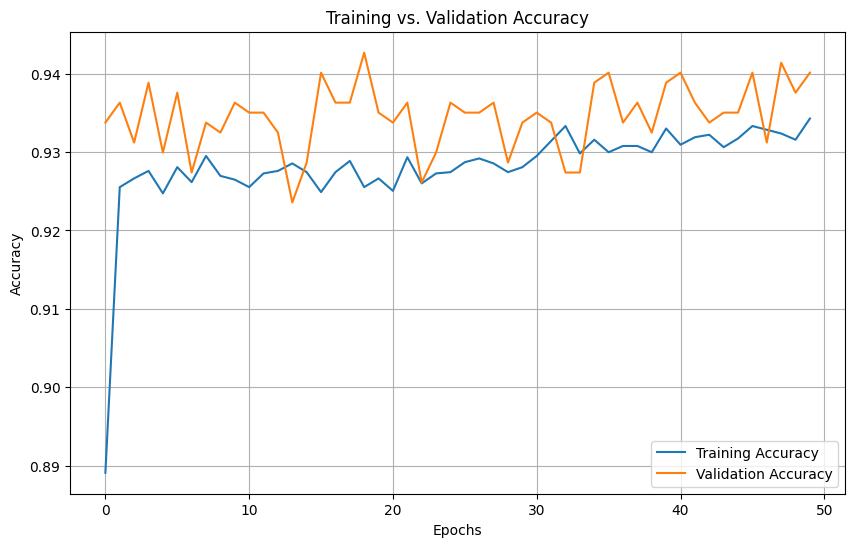

In [51]:
## Cool new feature! - model stores training accuracy per epoch and validation accuracy per
print(f"model acc : {simple_model.test(input=test_mlp[0], targets=test_mlp[1])}")
train_accs, val_accs = simple_model.get_accuracies()
epochs = range(simple_model.get_epochs())

plt.figure(figsize=(10, 6))

plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')


plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Grid search optimizer

#### Optimizer

In [52]:
class GridSearchOptimizer:
    def _generate_combinations(self):
        """
        Generates all combinations of hyperparameter values.
        """
        keys, values = zip(*self.param_grid.items())
        combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
        return combinations

    def _generate_hidden_sizes(self, min_layers, max_layers, neuron_options):
        """
        Generates a list of hidden layer sizes based on specified neuron options for each layer.
        
        Args:
            min_layers (int): Minimum number of layers.
            max_layers (int): Maximum number of layers.
            neuron_options (list): List of neuron numbers for each layer to choose from.
            
        Returns:
            list: A list of lists, where each list represents a possible combination of neuron counts.
        """
        sizes = []
        for num_layers in range(min_layers, max_layers + 1):
            for combination in itertools.product(neuron_options, repeat=num_layers):
                sizes.append(list(combination))
        return sizes
    
    
    def __init__(self, model, param_grid, train_data, val_data, batch_sizes, fixed_params, training_params, ohe=False, top_k = 5, logging_level="info"):
        """
        Initializes the Grid Search Optimizer.
        
        Args:
            model: A class representing your model, which should have a fit and evaluate method.
            param_grid: Dictionary with parameters names (str) as keys and lists of parameter settings to try as values.
            train_data: Tuple containing training data (input_train, target_train).
            val_data: Tuple containing validation data (input_val, target_val).
            batch_sizes: List of batch sizes to try
            fixed_params: Dict with param names (str) as keys and fixed param values
            training_params: Dict with training param names as keys and fixed param values
            ohe : boolean representing wether targets are one hot encoded
            top_k: top #k models to store at each time. Set to GridOptimizer.estimate_combinations to keep all
            logging_level: sets logging level for logger, reset when finished optimizing

            Note: 
            params not included in param_grid, fixed_params, or training_params will evaluate
            to their default values
        """
        # Set model and param dicts
        self.model = model
        self.param_grid = param_grid.copy()
        self.fixed_params = fixed_params.copy()
        self.training_params = training_params.copy()

        # Set data
        self.train_data = (train_data[0].copy(), train_data[1].copy())
        self.val_data = (val_data[0].copy(), val_data[1].copy())
        self.batch_sizes = batch_sizes

        # Initialize class params
        self.ohe = ohe
        self.top_k = top_k
        self.top_models = []
        self.top_k_models = []
        self.counter = 0

        # Setup logger
        self.logger = logging.getLogger("loggy")
        self.prev_logging_level = logging.getLevelName(self.logger.level)
        update_logger_level(logging_level)
        
        # Setup hidden sizes and combinations
        self.param_grid['hidden_sizes'] = self._generate_hidden_sizes(*param_grid['hidden_sizes'])
        self.combinations = self._generate_combinations()
        self.n_combinations = len(self.combinations) * len(self.batch_sizes)
        self.logger.info("OPTIMIZER INITIALIZED")
        self.logger.info(f"N COMBINATIONS : {self.n_combinations}\n")

    def optimize(self, k_folds = 5, use_subset=True, subset_ratio = 0.2, penalty_type = "none", penalty_factor = 0, stop_after_top_k = False, store_train_acc = False):
        """
        Finds optimal hyperparameter combination

            1. Finds top k preforming models (preferably on subset with k-fold cv) out of all possible
                combinations of hyperparams
            2. Resets, Trains, and Evaluates top k preforming models on full datasets
            3. finds top k models, resets heap and logger level
            

            NOTE : this method can take really long to run, use estimate combinations to check if
                it is feasible to run (each one will involve training a model)
            NOTE : storing top k model instances is really expensive, dont make top_k too big
            NOTE : get top model with get_top_model() and list of top k models with get_top_k_models()
                Format - (acc, params, batch_size, model)

            Args:
                k_folds: #folds to use with k-fold cv in _find_top_k(), no k-fold cv if k_folds < 2
                use_subset: boolean representing wether to use a subset in _find_top_k()
                subset_ration: ratio of subset to original set
                penalty_type: penalty type to use when calculating accuracy. ['none', 'abs', 'std', 'ratio']
                penalty_factor: factor to apply to penalty before substracting, different depending on penalty_type
                    automatically scaled for std : [-inf;0.05] -> [0.1;1] | [0.05;0.1] -> [1;5] | std ~ [0.1;inf] -> [5;10]
                    f.x for std factor ~ [0.1, 1] (scaled), for ratio factor ~= 1/2
                stop_after_top_k: stops after after _find_top_k
                store_train_acc: store training accuracy
        """
        # Store params
        self.k_folds = k_folds
        self.use_subset = use_subset
        self.subset_ratio = subset_ratio
        self.penalty_type = penalty_type
        self.penalty_factor = penalty_factor
        self.stop_after_top_k = stop_after_top_k
        self.store_train_acc = store_train_acc

        # Warning if not using subsets on large search space
        if not use_subset and self.n_combinations > 100:
            self.logger.warning(f"Optimizing for {self.n_combinations} with full dataset!")
        
        # Find top k on reduced dataset
        self._find_top_k() 

        # Find best of top k models on full dataset
        self._final_evaluate()

        # reset logger level
        update_logger_level(self.prev_logging_level)

        # Output top model acc & params
        model_info = self.get_top_model()
        print(f"\tTOP MODEL\t--\tACCURACY : {model_info['val_acc']}" + ('\t\t' + k + ':' + v) for k,v in model_info.items())


    def _find_top_k(self):
        """
        Executes the grid search optimization (preferably with k-fold CV and smaller subset)
        Finds top k performing models
        """
        # Setup
        self.logger.info(f"FIND TOP {self.top_k} MODELS")
        self.logger.info(f"Fixed Training Parameters : {self.training_params}")
        self.logger.info(f"Fixed Model Parameters : {self.fixed_params}" + ('\n' if self.k_folds > 1 else ''))
        if self.k_folds < 2:
            self.logger.info(f"No k-fold cross validation!\n")
        training_params = self.training_params.copy()

        # Setup data (no copy could be bad?)
        train_set = self.train_data
        val_set = self.val_data

        if self.use_subset:
            train_set = MLP_helper.get_subset(train_set[0], train_set[1], self.subset_ratio)
            val_set = MLP_helper.get_subset(val_set[0], val_set[1], self.subset_ratio)

        folds = [(train_set + val_set)] if self.k_folds < 2 else MLP_helper.k_fold_split(k_folds=self.k_folds, *train_set)

        # For progress bar
        percentages = range(0, 101, 2)
        previous_progress = set() 
        top_acc = - np.inf

        # Iterate through all possible combinations
        for combo in self.combinations:
            # Create model instance with params
            params = {**self.fixed_params, **combo}
            model_instance = self.model(**params)

            # Iterate through all possible batch sizes
            for batch_size in self.batch_sizes:
                # Progress bar implementation
                progress = self.counter / self.n_combinations * 100
                for threshold in percentages:
                    if threshold <= progress and threshold not in previous_progress:
                        previous_progress.add(threshold) 
                        logger.info(f"Progress: {threshold}% completed ({self.counter} / {self.n_combinations})\tbest accuracy : {top_acc}")  

                # Setup training params
                training_params["learning_rate"] = params["learning_rate"]
                training_params['batch_size'] = batch_size
                
                # Get accuracy and update top models
                val_accs, train_accs = self._validate_k_folds(model_instance, training_params, folds)
                accuracy = self._acc_with_penalty(val_accs, train_accs, self.penalty_type, self.penalty_factor)
                top_acc = max(top_acc, accuracy)
                
                model_info = {'model':model_instance, 'params':params, 'val_acc':accuracy, 'batch_size':batch_size}
                if self.store_train_acc: model_info['train_acc'] = np.mean(train_accs)
                    
                self._update_top_models(model_info)
            
                # Log and update counter
                self.logger.debug(f'Training model with params: {combo} and batch_size: {batch_size}')
                self.logger.debug(f"Validation accuracy: {accuracy}")
                self.counter+=1
        logger.info(f"Progress: {percentages[-1]}% completed ({self.counter} / {self.n_combinations})\tbest accuracy : {top_acc}\n") 
        gc.collect()
    
    def _final_evaluate(self):
        """
        Performs final evaluation with top k models on full training set
        Updates top models and extracts them to a list, resets heap
        """
        # Setup 
        self.logger.info("FINAL EVALUATION")
        training_params = self.training_params.copy()
        self.top_k_models = []
        
        while self.top_models:
            _, _, model_info = heapq.heappop(self.top_models)
            # setup params
            training_params['batch_size'] = model_info['batch_size']
            training_params['learning_rate'] = model_info['params']['learning_rate']
            model_instance = model_info['model']

            if not self.stop_after_top_k:
                # Reset and retrain model on full datsets, evaluate on validation set
                model_instance.reset()
                model_instance.set_epochs(1000)
                val_acc, train_acc = self._train_and_evaluate(model_instance, training_params, self.train_data, self.val_data)

                # Set model info
                model_info['val_acc'] = val_acc
                if self.store_train_acc: model_info['train_acc'] = train_acc
                
                self.counter +=1
                self.logger.info(
                    f"Model {self.counter - self.n_combinations} / {self.top_k}\t accuracy = {val_acc}" + 
                    ('\n' if self.counter - self.n_combinations >= self.top_k - 1 else '')
                )
                gc.collect()
            
            # Update top models
            self.top_k_models.append(model_info)

        # convert top models to list, sort, and format
        sorted_models = sorted(self.top_k_models, key=lambda x: x['val_acc'], reverse=True)
        
        # reset top models
        self.top_models = []
        self.top_k_models = sorted_models

    def _train_and_evaluate(self, model_instance, training_params, train_data, val_data):
        """
        Trains and evaluates model

        Args:
            model_instance : Initialzied model
            training_params : dict of training params, expects all except data
            input : tuple containing train and val input data
            targets: tuple containing train and val target data

        Returns:
            val_acc: validation accuracy
            train_acc: training accuracy
        """
        # Unwrap data tuples
        training_params['input'], training_params['targets'] = train_data
        training_params['input_val'], training_params['target_val'] = val_data

        # Train model instance
        model_instance.train(**training_params)

        # Get training and validation accuracy
        val_acc = model_instance.test( 
            input = training_params['input_val'], targets = training_params['target_val'],
            batch_size = training_params['batch_size'], ohe = self.ohe)
        train_acc = model_instance.test(
            input = training_params['input'], targets = training_params['targets'],
            batch_size = training_params['batch_size'], ohe = self.ohe)
        gc.collect()

        return val_acc, train_acc

    def _validate_k_folds(self, model_instance, training_params, folds):
        """
        Validates model performance using k-fold cv
        Sets up data (optional subset), accumulates accuracies over folds
        If self.k_folds < 2 -> evaluates model on full train and validation sets

        Args:
            model_instance: model instance to validate
            training_params: training params to use

        Returns:
            validation and training accuracy
        """
        # accumulate accuracies
        val_accs = []
        train_accs = []
        for input_train, targets_train, input_val, targets_val in folds:
            val_acc, train_acc = self._train_and_evaluate(model_instance, training_params, (input_train, targets_train), (input_val, targets_val))
            val_accs.append(val_acc)
            train_accs.append(train_acc)
        
        return val_accs, train_accs

    def _update_top_models(self, model_info):
        """
        Updates the list of top models
        Implemented with min heap, pushes untill k in heap, then pushes and pops smallest accuracy

        Args:
            model_info: val_acc, 
        """
        entry = (-model_info['val_acc'], self.counter, model_info)
        
        if len(self.top_models) < self.top_k:
            heapq.heappush(self.top_models, entry)
        else:
            heapq.heappushpop(self.top_models, entry)

    def _acc_with_penalty(self, val_accs, train_accs, penalty_type, penalty_factor):
        """
        Adjusts accuracy with an overfitting penalty, ensuring penalty_factor scales within [0, 1].

        Args:
            val_accs: Validation accuracies as a numpy array or a scalar.
            train_accs: Training accuracies as a numpy array or a scalar.

        Returns:
            Adjusted validation accuracy accounting for the penalty.
        """
        val_accs = np.atleast_1d(val_accs)
        train_accs = np.atleast_1d(train_accs)

        val_acc_avg = np.mean(val_accs)

        if penalty_type is None or penalty_factor <= 0 or penalty_type.lower() == "none":
            return val_acc_avg

        # Calculate average absolute difference between validation and training accuracies
        avg_diff = np.mean(np.abs(val_accs - train_accs))

        if penalty_type.lower() == "abs":
            penalty = penalty_factor * avg_diff

        elif penalty_type.lower() == "std":
            std_diff = np.std(val_accs - train_accs)
            penalty = penalty_factor * (1 / (1 + np.exp(-std_diff)))

        elif penalty_type.lower() == "ratio":
            ratio = avg_diff / val_acc_avg
            penalty = penalty_factor * min(ratio, 1)

        else:
            self.logger.warning(f"Unknown penalty type: {penalty_type}")
            return val_acc_avg

        adjusted_acc = max(val_acc_avg - penalty, 0)
        if adjusted_acc <= 1e-3: 
            self.logger.info(f"Found overfit model : acc = {val_acc_avg}  penalty = {penalty}  avg diff = {avg_diff}")
        return adjusted_acc
    
    
    def get_top_model(self):
        """
        Returns the top model based on validation accuracy.
        """
        if not self.top_k_models:
            raise ValueError(f"Optimization has not been run yet or no models were evaluated.")
        return self.top_k_models[0]

    def get_top_k_models(self):
        """
        Returns a list of the top k models sorted by validation accuracy.
        """
        if not self.top_k_models:
            raise ValueError(f"Optimization has not been run yet or no models were evaluated.")
        return self.top_k_models
    

    @staticmethod
    def estimate_combinations(param_grid, batch_sizes):
        """
        Estimates the total number of hyperparameter combinations, including different batch sizes.

        Args:
            param_grid (dict): The grid of parameters to search, with each key being a parameter name
                               and each value being a list of values to try.
            batch_sizes (list): List of batch sizes to try.

        Returns:
            int: The estimated number of combinations.
        """
        total_combinations = 1  # Start with a base of 1

        # Iterate through each parameter in the grid
        for key, values in param_grid.items():
            if key == 'hidden_sizes':
                # Special handling for hidden_sizes
                min_layers, max_layers, neuron_options = values
                # Generate all possible hidden layer sizes and count them
                layer_sizes_count = sum(len(neuron_options)**layers for layers in range(min_layers, max_layers + 1))
                total_combinations *= layer_sizes_count
            else:
                total_combinations *= len(values)

        # Multiply by the number of batch sizes
        total_combinations *= len(batch_sizes)

        return total_combinations